# Postprocessing and plots

The outputlib module
https://oemof.readthedocs.io/en/stable/api/oemof.outputlib.html

Copied from: https://github.com/rl-institut/workshop
Not discussed in oemof workshop.

## Imports pandas, matplotlib and oemof

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

import oemof.solph as solph
import oemof.outputlib as outputlib
from oemof.tools.economics import annuity

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = [20.0, 7.0]
rcParams['font.size'] = 25

## Restore the energysystem with results

In [3]:
energysystem = solph.EnergySystem()
energysystem.restore(dpath='./', filename='energy.oemof')

'Attributes restored from: ./energy.oemof'

## Filter the dictionary using outputlib
### Get all the flows into and out of the electricity bus


In [4]:
labeled_results = outputlib.processing.convert_keys_to_strings(energysystem.results['main'])
labeled_results[('chp_gas', 'electricity')].keys()

dict_keys(['scalars', 'sequences'])

In [5]:
results_bus_el = outputlib.views.node(energysystem.results['main'], 'electricity')['sequences']

In [6]:
# results_bus_th = outputlib.views.node(energysystem.results['main'], 'heat')['sequences']
results_bus_el.columns = [col[0] for col in results_bus_el.columns]
results_bus_el.index.name = 'timeindex'
results_bus_el.head()

,"(chp_gas, electricity)","(electricity, demand_el)","(electricity, excess_el)","(electricity, storage_el)","(pp_coal, electricity)","(pv, electricity)","(shortage_el, electricity)","(storage_el, electricity)","(wind, electricity)"
timeindex,,,,,,,,,
2016-01-01 00:00:00,4.408357,52.169653,0.0,0.0,33.556064,0.0,0.0,0.0,14.205231
2016-01-01 01:00:00,4.501334,52.169653,0.0,0.0,33.225089,0.0,0.0,0.0,14.443230
2016-01-01 02:00:00,4.707776,47.392644,0.0,0.0,23.039620,0.0,0.0,0.0,19.645248
2016-01-01 03:00:00,5.221512,45.197772,0.0,0.0,15.826051,0.0,0.0,0.0,24.150209
2016-01-01 04:00:00,6.525410,44.189789,0.0,0.0,11.931793,0.0,0.0,0.0,25.732585


### Prepare input parameters for postprocessing

In [7]:
params = energysystem.params
params.keys()

dict_keys([("<oemof.solph.network.Bus: 'coal'>", "<oemof.solph.network.Transformer: 'pp_coal'>"), ("<oemof.solph.network.Bus: 'gas'>", "<oemof.solph.network.Transformer: 'chp_gas'>"), ("<oemof.solph.network.Bus: 'electricity'>", "<oemof.solph.network.Sink: 'demand_el'>"), ("<oemof.solph.network.Bus: 'electricity'>", "<oemof.solph.components.GenericStorage: 'storage_el'>"), ("<oemof.solph.network.Bus: 'electricity'>", "<oemof.solph.network.Sink: 'excess_el'>"), ("<oemof.solph.network.Bus: 'heat'>", "<oemof.solph.network.Sink: 'demand_th'>"), ("<oemof.solph.network.Bus: 'heat'>", "<oemof.solph.components.GenericStorage: 'storage_th'>"), ("<oemof.solph.network.Source: 'source_gas'>", "<oemof.solph.network.Bus: 'gas'>"), ("<oemof.solph.network.Source: 'source_coal'>", "<oemof.solph.network.Bus: 'coal'>"), ("<oemof.solph.network.Source: 'wind'>", "<oemof.solph.network.Bus: 'electricity'>"), ("<oemof.solph.network.Source: 'pv'>", "<oemof.solph.network.Bus: 'electricity'>"), ("<oemof.solph.ne

In [8]:
def convert_params_to_dataframe(params):
    r"""
    Collect all parameters in one pd.DataFrame
    """    
    param_df = pd.DataFrame()
    for key in params.keys():
        new_row = params[key]['scalars']
        label = tuple(map(str, key)) if isinstance(key, tuple) else str(key)
        new_row['label'] = label
        new_row['from'] = label[0]
        new_row['to'] = label[1]
        param_df = param_df.append(new_row, ignore_index=True)
        
    param_df['fixed'] = param_df['fixed'].astype('bool')
    param_df = param_df[param_df.columns.drop('label').insert(0, 'label')]
    param_df = param_df.set_index('label')
    return param_df

params_df = convert_params_to_dataframe(params)
params_df.head()

,fixed,from,max,min,negative_gradient_costs,positive_gradient_costs,to,variable_costs,nominal_value,balanced,...,conversion_factors_electricity,conversion_factors_gas,conversion_factors_heat,inflow_conversion_factor,initial_storage_level,loss_rate,max_storage_level,min_storage_level,nominal_storage_capacity,outflow_conversion_factor
label,,,,,,,,,,,,,,,,,,,,,
"(coal, pp_coal)",False,coal,1.0,0.0,0.0,0.0,pp_coal,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(gas, chp_gas)",False,gas,1.0,0.0,0.0,0.0,chp_gas,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(electricity, demand_el)",True,electricity,1.0,0.0,0.0,0.0,demand_el,0.0,85.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(electricity, storage_el)",False,electricity,1.0,0.0,0.0,0.0,storage_el,0.0,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(electricity, excess_el)",False,electricity,1.0,0.0,0.0,0.0,excess_el,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Define color dictionary

Use color palette generators to generate suitable colors, e.g.:     
http://javier.xyz/cohesive-colors/  
https://colourco.de/  
http://seaborn.pydata.org/tutorial/color_palettes.html  

In [9]:
cdict = {('chp_gas', 'electricity'): '#eeac7e',
        ('pp_coal', 'electricity'): '#0f2e2e',
        ('pv', 'electricity'): '#ffde32',
        ('wind', 'electricity'): '#4ca7c3',
        ('electricity', 'demand_el'): '#000000',
        ('electricity', 'storage_el'): '#E04644',
        ('storage_el', 'electricity'): '#B7D968',
        ('electricity', 'excess_el'): '#C748E2',
        ('shortage_el', 'electricity'): '#B576AD'}

## Plot renewable feedin and demand

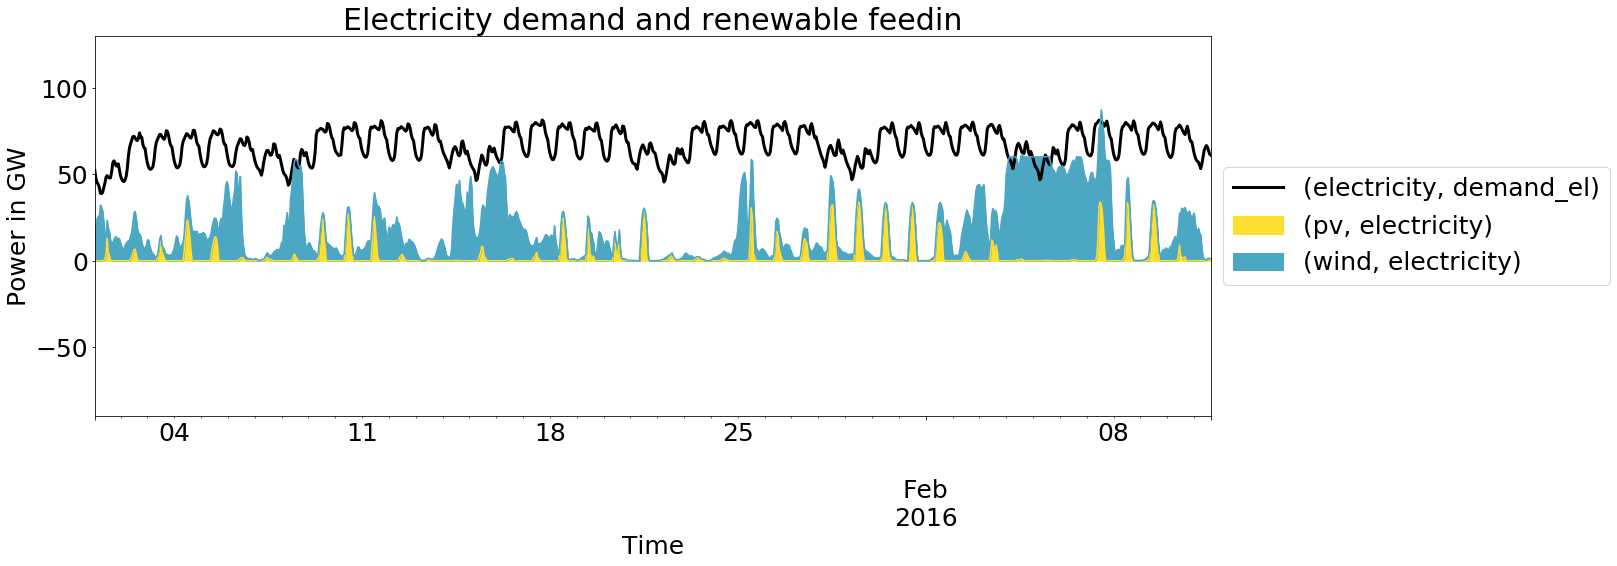

In [10]:
seq_re = results_bus_el[[('pv', 'electricity'), ('wind', 'electricity')]]
seq_demand = results_bus_el[('electricity', 'demand_el')]

range_low = 1
range_high = 1000

fig, ax = plt.subplots()
color = [cdict[column] for column in seq_re.columns]
seq_demand[range_low:range_high].plot(ax=ax, linewidth=3, color='k')
seq_re[range_low:range_high].plot.area(ax=ax, color=color)
ax.set_ylim(-90, 130)
ax.set_ylabel('Power in GW')
ax.set_xlabel('Time')
ax.set_title('Electricity demand and renewable feedin')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # place legend outside of plot
plt.show()

## Plot all dispatch

In [11]:
produced_el = results_bus_el.drop(('electricity', 'demand_el'), axis=1)
produced_el = produced_el.clip(lower=0)
produced_el[('electricity', 'storage_el')] *= -1

In [12]:
sorted_columns = [('electricity', 'storage_el'),
                  ('storage_el', 'electricity'),
                  ('wind', 'electricity'),
                  ('pv', 'electricity'),
                  ('pp_coal', 'electricity'),
                  ('chp_gas', 'electricity'),
                  ('electricity', 'excess_el'),
                  ('shortage_el', 'electricity')]

produced_el = produced_el[sorted_columns]

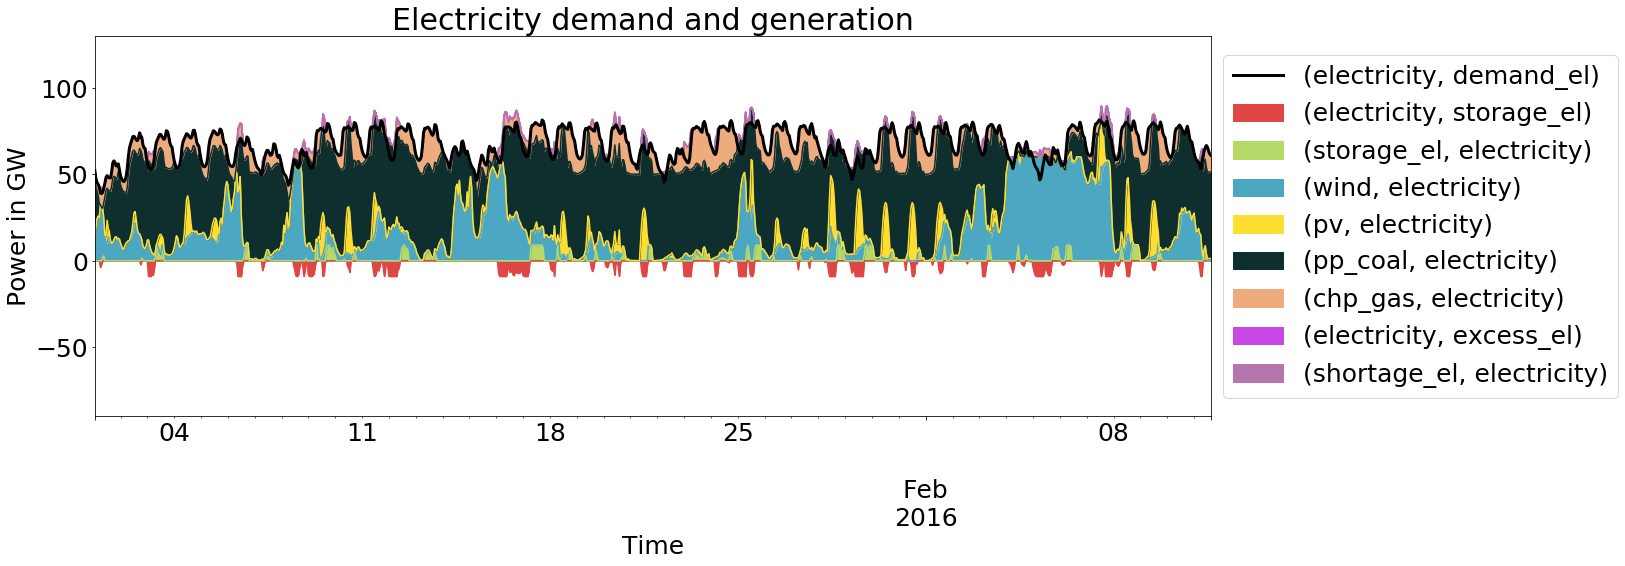

In [13]:
fig, ax = plt.subplots()
color = [cdict[column] for column in produced_el.columns]
produced_el[range_low:range_high].plot.area(ax=ax, color=color)
seq_demand[range_low:range_high].plot(c='k', linewidth=3)
ax.set_ylim(-90, 130)
ax.set_ylabel('Power in GW')
ax.set_xlabel('Time')
ax.set_title('Electricity demand and generation')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # place legend outside of plot
plt.show()

### Plot Jahresdauerlinie

In [14]:
sorted_sequences = pd.DataFrame()
for column in results_bus_el.columns:
    sorted_sequences[column]=sorted(results_bus_el[column], reverse=True)

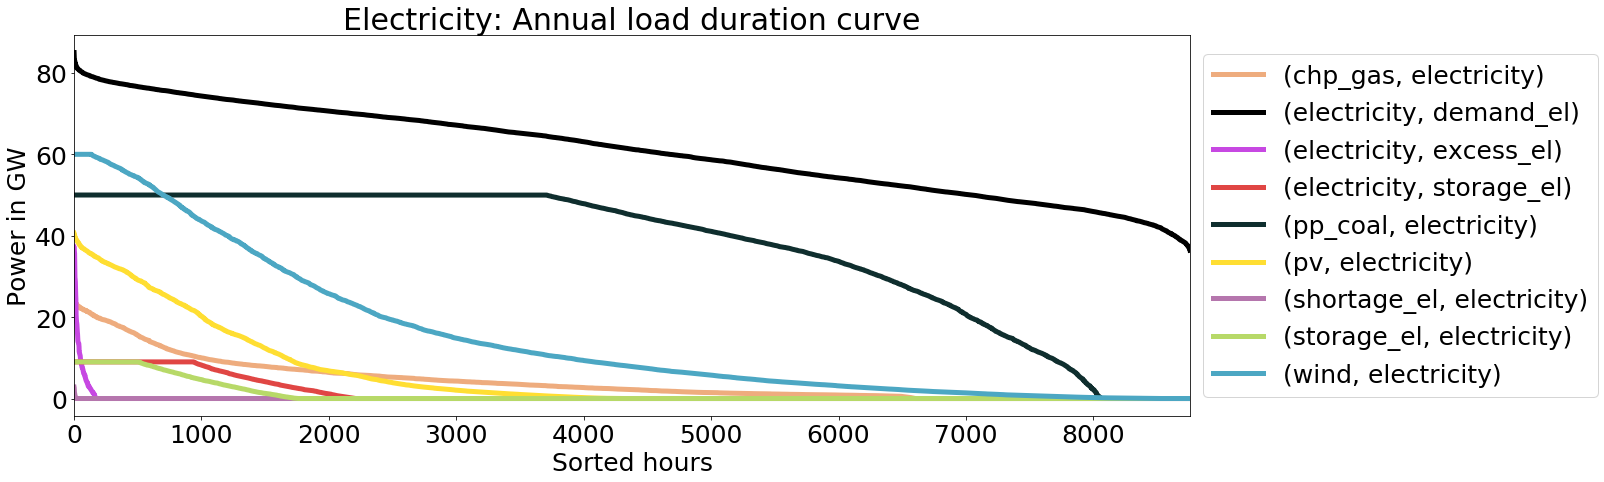

In [15]:
fig, ax = plt.subplots()
color = [cdict[column] for column in sorted_sequences.columns]
sorted_sequences.plot(ax=ax, color=color, linewidth=5)
ax.set_ylabel('Power in GW')
ax.set_xlabel('Sorted hours')
ax.set_title('Electricity: Annual load duration curve')
legend = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # place legend outside of plot
plt.show()

## Calculate metrics and indicators

### Installierte Leistung für Technologie i
$$P_{inst,i}$$

In [16]:
to_bus_el = [i[1]=='electricity' for i in params_df.index]
params_df_to_el = params_df.loc[to_bus_el]
params_df_to_el

,fixed,from,max,min,negative_gradient_costs,positive_gradient_costs,to,variable_costs,nominal_value,balanced,...,conversion_factors_electricity,conversion_factors_gas,conversion_factors_heat,inflow_conversion_factor,initial_storage_level,loss_rate,max_storage_level,min_storage_level,nominal_storage_capacity,outflow_conversion_factor
label,,,,,,,,,,,,,,,,,,,,,
"(wind, electricity)",True,wind,1.0,0.0,0.0,0.0,electricity,0.000000e+00,60.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(pv, electricity)",True,pv,1.0,0.0,0.0,0.0,electricity,0.000000e+00,43.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(pp_coal, electricity)",False,pp_coal,1.0,0.0,0.0,0.0,electricity,0.000000e+00,50.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(chp_gas, electricity)",False,chp_gas,1.0,0.0,0.0,0.0,electricity,0.000000e+00,40.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(storage_el, electricity)",False,storage_el,1.0,0.0,0.0,0.0,electricity,0.000000e+00,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(shortage_el, electricity)",False,shortage_el,1.0,0.0,0.0,0.0,electricity,1.000000e+15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
p_inst = params_df_to_el['nominal_value'].loc[params_df_to_el['nominal_value']>0]
p_inst = p_inst.sort_index()
p_inst = p_inst.rename('installed_capacity')
p_inst

label
(chp_gas, electricity)       40.0
(pp_coal, electricity)       50.0
(pv, electricity)            43.0
(storage_el, electricity)     9.0
(wind, electricity)          60.0
Name: installed_capacity, dtype: float64

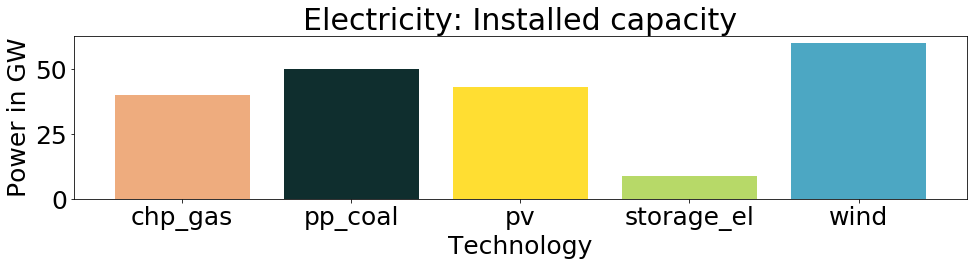

In [18]:
fig, ax = plt.subplots(figsize=(16,3))
color = [cdict[label] for label in p_inst.index]
x = [label[0] for label in p_inst.index]
height = p_inst.values
plt.bar(x=x, height=height, color=color)
ax.set_ylabel('Power in GW')
ax.set_xlabel('Technology')
ax.set_title('Electricity: Installed capacity')
plt.show()

### Jährliche Energiemenge für Technologie i
$$E_{ges,i} = \sum_t P_{t,i} \cdot \Delta t$$

In [19]:
to_bus_el = [column for column in results_bus_el.columns if column[1]=='electricity']
yearly_energy = results_bus_el[to_bus_el].sum()
yearly_energy = yearly_energy.sort_index()
yearly_energy = yearly_energy.rename('yearly_energy')
yearly_energy

(chp_gas, electricity)         36016.100699
(pp_coal, electricity)        321693.382017
(pv, electricity)              46995.301771
(shortage_el, electricity)        14.823550
(storage_el, electricity)       9450.284847
(wind, electricity)           134168.601611
Name: yearly_energy, dtype: float64

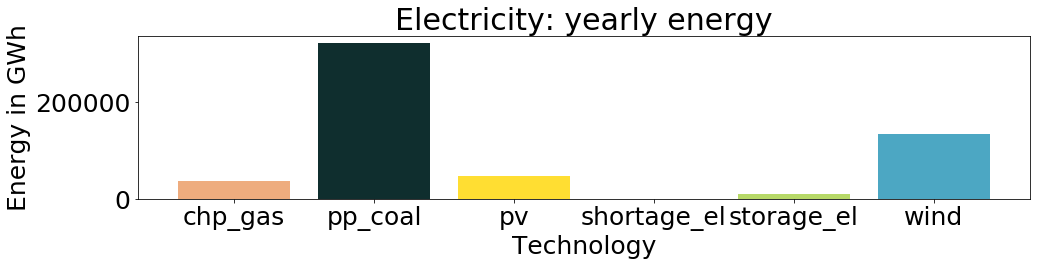

In [20]:
fig, ax = plt.subplots(figsize=(16,3))
x = [label[0] for label in yearly_energy.index]
height = yearly_energy.values
color = [cdict[label] for label in yearly_energy.index]
plt.bar(x=x, height=height, color=color)
ax.set_ylabel('Energy in GWh')
ax.set_xlabel('Technology')
ax.set_title('Electricity: yearly energy')
plt.show()

### Volllaststunden von Technologie i
$$t_{Volllast, i} = \frac{E_{ges,i}}{P_{inst,i}}$$

In [21]:
full_load_hours =  yearly_energy * 1/p_inst
full_load_hours = full_load_hours.rename('full_load_hours')
full_load_hours

(chp_gas, electricity)         900.402517
(pp_coal, electricity)        6433.867640
(pv, electricity)             1092.913995
(shortage_el, electricity)            NaN
(storage_el, electricity)     1050.031650
(wind, electricity)           2236.143360
Name: full_load_hours, dtype: float64

### Deckungsgrad von Technologie i
$$\frac{E_{ges,i}}{\sum_i E_{ges,i}}, \ for \ i \ \neq \ storage $$

In [22]:
yearly_production = yearly_energy.drop(('storage_el', 'electricity'))
coverage_ratio = (yearly_production * 1/(yearly_production.sum()))
coverage_ratio = coverage_ratio.rename('coverage_ratio')
coverage_ratio

(chp_gas, electricity)        0.066834
(pp_coal, electricity)        0.596958
(pv, electricity)             0.087208
(shortage_el, electricity)    0.000028
(wind, electricity)           0.248973
Name: coverage_ratio, dtype: float64

### Speicherzyklen
https://github.com/oemof/cydets

Dambrowski, Jonny; Pichlmaier, Simon & Jossen, Andreas. Mathematical methods for classification of state-of-charge time series for cycle lifetime prediction. Advanced Automotive Battery Conference. Mainz, Germany. 2012.

In [23]:
from cydets.algorithm import detect_cycles


state_of_charge_el = string_results[('storage_el', 'None')]['sequences']['capacity']

cycles = detect_cycles(state_of_charge_el)
print(len(cycles))
cycles.head()

ModuleNotFoundError: No module named 'cydets'

In [ ]:
range_low = 1
range_high = 3000

fig, ax = plt.subplots()
charge_el = charge_el.clip(lower=0)
charge_el[range_low:range_high].plot.area(ax=ax)
for timepoint in cycles['t_start']:
    ax.axvline(x=timepoint, c='r', alpha=0.3)
ax.set_ylabel('State of Charge in GWh')
ax.set_xlabel('Time')
ax.set_title('Charging profile of electricity storage and detected cycles')
plt.show()

### Gesamte Treibhausgasemissionen

Zur Verteilung von Emissionen auf Strom und Wärme siehe diesen Vergleich verschiedener Allokationsmethoden:

https://www.ffe.de/download/wissen/334_Allokationsmethoden_CO2/ET_Allokationsmethoden_CO2.pdf


In [ ]:
emission_factors = params_df['emission_factor'].loc[params_df['emission_factor']>0]
emission_factors # kgCO2/kWh

In [ ]:
string_results = outputlib.processing.convert_keys_to_strings(energysystem.results['main'])
flows_with_emissions = pd.concat([string_results[i]['sequences']['flow'].rename(i)  for i in emission_factors.index], axis=1)
flows_with_emissions.sum() # GWh

In [ ]:
emissions = emission_factors * flows_with_emissions.sum()
emissions = emissions.rename('emissions')
emissions # kgCO2/kWh * GWh = 1e6 t CO2
# 0.8 Gt CO2

### Gesamtkosten Betrieb
$$\sum_{i} (C_{FOM,i} + \sum_t P_{t, i} C_{VOM})$$

In [ ]:
variable_costs = params_df['variable_costs'][params_df['variable_costs']>0]
variable_costs # Eur/GWh

In [ ]:
flows_with_variable_costs = pd.concat([string_results[i]['sequences']['flow'].rename(i)  for i in variable_costs.index], axis=1)
summed_variable_costs = variable_costs * flows_with_variable_costs.sum()
summed_variable_costs = summed_variable_costs.rename('summed_variable_costs') 
summed_variable_costs # Eur

### Gesamtkosten Investition
$$\sum_{i} C_{capital,i} P_{inst,i}$$

In [ ]:
overnight_costs = pd.Series({('chp_gas', 'electricity'): 888.5, # EUR/kWh
                   ('pp_coal', 'electricity'): 1554.8,
                   ('pv', 'electricity'): 1000,
                   ('storage_el', 'electricity'): 552,
                   ('wind', 'electricity'): 1377.1}).rename('overnight_cost')

overnight_costs = overnight_costs * 1e6 # kwh -> GWh

investment_periods = pd.Series({('chp_gas', 'electricity'): 30,
                      ('pp_coal', 'electricity'): 40,
                      ('pv', 'electricity'): 25,
                      ('storage_el', 'electricity'): 10,
                      ('wind', 'electricity'): 25}).rename('investment_period')

wacc = 0.05
def get_annuity(df):
    return annuity(df['overnight_cost'], df['investment_period'], df['wacc'])

annuity_calculation = pd.concat([overnight_costs, investment_periods], axis=1)
annuity_calculation['wacc'] = wacc
annuity_calculation['annuity'] = annuity_calculation.apply(get_annuity, axis=1)
annuity_calculation

In [ ]:
investment_costs = annuity_calculation['annuity'] * p_inst
investment_costs = investment_costs.rename('investment_costs')
investment_costs

## Gesamtübersicht

In [ ]:
pd.concat([p_inst,
           yearly_energy,
           full_load_hours,
           coverage_ratio,
           emissions,
           summed_variable_costs,
           investment_costs],
          sort=True,
          axis=1)